In [1]:
import numpy as np
import xarray as xr
import rasterio as rio
import rioxarray
import matplotlib.pyplot as plt
import xdem 
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.optimize import lsq_linear
import cvxpy as cp
import geopandas as gpd
import seaborn as sns
import scipy.interpolate as interp

## open datasets

In [2]:
data_path = '/mnt/Backups/gbrench/repos/rg_uavsar/data'

# open data 
ds = xr.open_dataset(f'{data_path}/combined/stack_20230725_20230925.zarr', chunks='auto', engine='zarr')
ds = ds.rio.write_crs('EPSG:32613')

ns_da = xr.open_dataarray(f'{data_path}/combined/ns_disp.tif').squeeze()
ew_da =xr.open_dataarray(f'{data_path}/combined/ew_disp.tif').squeeze()
ud_da =xr.open_dataarray(f'{data_path}/combined/ud_disp.tif').squeeze()

ds['ns_displacement'] = (('y', 'x'), ns_da.values)
ds['ew_displacement'] = (('y', 'x'), ew_da.values)
ds['ud_displacement'] = (('y', 'x'), ud_da.values)

In [3]:
# calculate total displacement and velocity
ds['total_displacement'] = np.sqrt(ds.ns_displacement**2 + ds.ew_displacement**2 + ds.ud_displacement**2)
ds['ns_velocity'] = (ds['ns_displacement']/62)*365.25
ds['ew_velocity'] = (ds['ew_displacement']/62)*365.25
ds['ud_velocity'] = (ds['ud_displacement']/62)*365.25
ds['total_velocity'] = (ds['total_displacement']/62)*365.25

In [4]:
ds['elevation'] = ds.height.mean(dim='swatch')

In [5]:
transform = (5.322144725472049309, 0.0, ds.elevation.isel(x=0, y=0).x.item(), 0.0, 5.322144725472049309, ds.elevation.isel(x=0, y=0).x.item())
# load to xdem
dem = xdem.DEM.from_array(ds.elevation.values, transform, crs='EPSG:32613')
# calculate slope 
ds['slope'] = (('y', 'x'), xdem.terrain.slope(dem).data.data)

/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/geoutils/raster/raster.py:1891: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(


## first pass: single rock glacier

In [6]:
rg_fn = f'../mapping/polygons/example_rg1.shp'
rg_gdf = gpd.read_file(rg_fn)

In [7]:
# clip to rock glacier bounds
minx, miny, maxx, maxy = rg_gdf.total_bounds
padding = 100 # pad by 100 m
rg_ds = ds.rio.clip_box(minx=minx-padding, miny=miny-padding, maxx=maxx+padding, maxy=maxy+padding)
rg_ds = rg_ds.fillna(0)

In [8]:
# create mask
mask = ~rg_ds.elevation.rio.clip(rg_gdf.geometry.values, crs=rg_gdf.crs, drop=False).isnull()
rg_ds['mask'] = (('y', 'x'), mask.values)

In [ ]:
# # simple approach with linear least squares
# # Calculate the vector of horizontal components of landslide surface velocity
# rg_ds['usurf'] = np.sqrt(rg_ds['ew_velocity']**2 + rg_ds['ns_velocity']**2)

# # Define the constant f
# f = 0.75

# # Define the matrices and vectors for the linear system
# u_d = rg_ds['ud_velocity'].values.flatten()
# X = sp.diags([f * rg_ds['usurf'].values.flatten()], [0])
# b = rg_ds['usurf'].values.flatten() * rg_ds['slope'].values.flatten() - u_d

# # Define the regularization parameter and matrix
# lambda_ = 1
# T = sp.eye(len(u_d))  # Identity matrix for simplicity
# nabla2 = sp.diags([1, -2, 1], [-1, 0, 1], shape=(len(u_d), len(u_d)))

# # Define the system of equations
# A = sp.vstack([X, lambda_ * T @ nabla2])
# b = np.hstack([b, np.zeros(len(u_d))])

# # Solve the system with nonnegative constraints
# result = lsq_linear(A, b, bounds=(0, np.inf))

# # Reshape the solution to the original grid shape
# thickness = result.x.reshape(rg_ds['total_displacement'].shape)

# # Add the thickness to the dataset
# rg_ds['thickness'] = (('y', 'x'), thickness)

In [64]:
def calculate_b_vector(u_surf, slope, ud_velocity):
    dzdxy = np.tan(np.radians(slope))
    bg = u_surf*dzdxy-ud_velocity

    return bg

def create_matrix_and_vector(u, v, bg, mask):
    # Apply mask
    u = mask * u
    v = mask * v
    bg = mask * bg

    # Reshape arrays to vectors
    b = bg.flatten()

    # Calculate A matrix
    A = calculate_A_matrix(u, v)

    return A, b

def calculate_A_matrix(u, v):
    # Sizes
    nr, nc = u.shape
    lenh = nr * nc

    # Reshape arrays to vectors
    u = u.flatten()
    v = v.flatten()

   # Create vectors for diagonals of matrix A
    d = np.ones(lenh)
    d1cy = sp.diags([d, 2 * d, d, -d, -2 * d, -d], [-nr - 1, -1, nr - 1, -nr + 1, 1, nr + 1], shape=(lenh, lenh))
    d1cx = sp.diags([-d, -2 * d, -d, d, 2 * d, d], [-nr - 1, -nr, -nr + 1, nr - 1, nr, nr + 1], shape=(lenh, lenh))
    uv0 = d1cx @ u + d1cy @ v

    # Rest of diagonals
    d1 = np.concatenate([(-u[nr + 1:] + v[nr + 1:]), np.zeros(nr + 1)])
    d2 = np.concatenate([-2 * u[nr:], np.zeros(nr)])
    d3 = np.concatenate([(-u[nr - 1:] - v[nr - 1:]), np.zeros(nr - 1)])
    d4 = np.concatenate([2 * v[1:], [0]])
    d5 = np.concatenate([[0], -2 * v[:-1]])
    d6 = np.concatenate([np.zeros(nr - 1), (u[:lenh - nr + 1] + v[:lenh - nr + 1])])
    d7 = np.concatenate([np.zeros(nr), 2 * u[:lenh - nr]])
    d8 = np.concatenate([np.zeros(nr + 1), (u[:lenh - nr - 1] - v[:lenh - nr - 1])])

    # Put all diagonals together to create A
    A = sp.diags([d1, d2, d3, d4, uv0, d5, d6, d7, d8], [-nr - 1, -nr, -nr + 1, -1, 0, 1, nr - 1, nr, nr + 1], shape=(lenh, lenh))

    return A.toarray()

def generalized_cross_validation(A, b, m, arange, numpts, plots):
    av = 10 ** np.linspace(arange[0], arange[1], numpts)
    nr, nc = m.shape
    lenh = nr * nc
    h = np.zeros((nr, nc, numpts))
    g = np.zeros(numpts)
    mpts = A.shape[0]

    for k in range(numpts):
        print(f'iteration {k+1}/{numpts}, damping: {av[k]}')
        htemp, ri, _, B = solve_lagrangian(A, b, m, av[k])
        h[:, :, k] = htemp
        AA = A @ np.linalg.inv(A.T @ A + (av[k] ** 2) * B.T @ B) @ A.T
        I = np.eye(mpts)
        g[k] = mpts * (ri ** 2) / (np.trace(I - AA) ** 2)

    aq = np.linspace(np.log10(min(av)), np.log10(max(av)), 10000)
    gq = np.interp(aq, np.log10(av), g)
    abest = 10 ** aq[np.argmin(gq)]
    hbest = solve_lagrangian(A, b, m, abest)[0]

    if plots:
        plt.figure()
        plt.semilogx(av, g, '-ok')
        plt.semilogx(10 ** aq, gq, 'r')
        plt.semilogx(abest, min(gq), 'xb')
        plt.xlabel('Damping Parameter')
        plt.ylabel('G Function')
        plt.show()

    return h, hbest, g, av, abest

def solve_lagrangian(A, b, m, a):
    nr, nc = m.shape
    lenh = nr * nc
    m = m.flatten()

    # Create smoothing matrix from finite difference approximation of Laplacian
    d = np.ones(lenh)
    B = sp.diags([0.5 * d, d, 0.5 * d, d, -6 * d, d, 0.5 * d, d, 0.5 * d],
                 [-nr - 1, -nr, -nr + 1, -1, 0, 1, nr - 1, nr, nr + 1], shape=(lenh, lenh))

    # Set constraints
    hmax = 9999  # Set maximum h
    hlow = 0.1  # Tolerance for h in stable terrain
    lb = np.zeros(lenh)  # h >= 0 everywhere
    ub = hlow + hmax * m  # h < hlow in stable terrain only

    # Invert for h with non-negative constraints
    h = cp.Variable(lenh)
    objective = cp.Minimize(cp.norm(A @ h - b) + a * cp.norm(B @ h))
    constraints = [h >= lb, h <= ub]
    prob = cp.Problem(objective, constraints)
    prob.solve()

    rnorm = np.linalg.norm(A @ h.value - b)
    snorm = np.linalg.norm(B @ h.value)
    

    h = h.value.reshape(nr, nc)
    lb = lb.reshape(nr, nc)
    ub = ubreshape(nr, nc)
    return h, rnorm, snorm, B, lb, ub

In [ ]:
rg_ds['u_surf'] = np.sqrt(rg_ds['ew_velocity']**2 + rg_ds['ns_velocity']**2)

# Define the constant f
f = 0.75

# Calculate b vector
bg = calculate_b_vector(rg_ds['u_surf'].values, rg_ds['slope'].values, rg_ds['ud_velocity'].values)

# Create matrix A and vector b
A, b = create_matrix_and_vector(rg_ds['ew_velocity'].values, rg_ds['ns_velocity'].values, bg, rg_ds['mask'].values)

# Solve the system with nonnegative constraints
result = lsq_linear(A, b, bounds=(0, np.inf))

# Reshape the solution to the original grid shape
thickness = result.x.reshape(rg_ds['total_displacement'].shape)

# # test solving
# hbest, rnorm, snorm, B, lb, ub = solve_lagrangian(A, b, rg_ds['mask'].values, 1)

# # Use generalized cross-validation to select the best damping parameter
# numpts = 2
# arange = [-1, 0] # powers of 10
# h, hbest, g, av, abest = generalized_cross_validation(A, b, rg_ds['mask'].values, arange, numpts, plots=False)

# Add the thickness to the dataset
rg_ds['thickness'] = (('y', 'x'), thickness)

In [ ]:
#rg_ds = rg_ds.rio.clip(rg_gdf.geometry.values, crs=rg_gdf.crs, drop=True)

(9800.0, 10000.0)

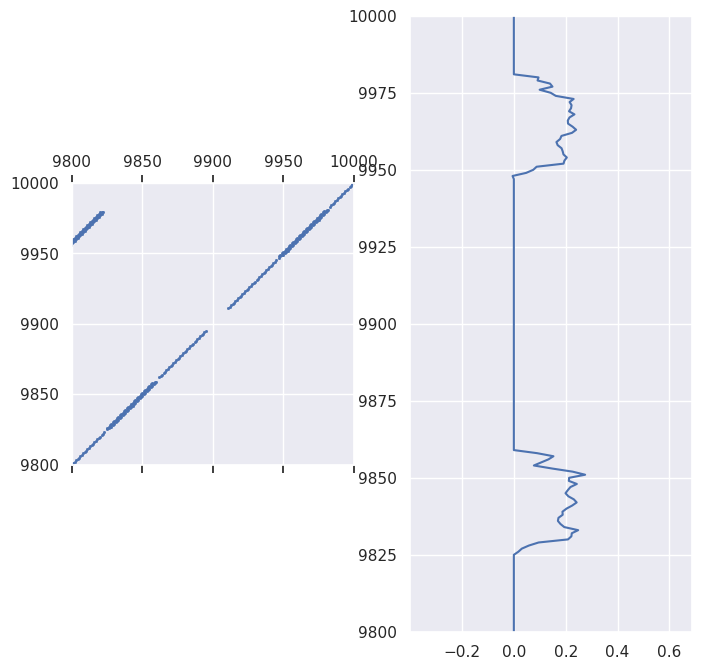

In [76]:
# Spy plot
f, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].spy(A, markersize=1)
ax[0].set_xlim(9800, 10000)
ax[0].set_ylim(9800, 10000)
ax[1].plot(b, np.arange(len(b)), markersize=1)
ax[1].set_ylim(9800, 10000)

In [ ]:
sns.set_theme()
f, ax = plt.subplots()
#ax.imshow(b.reshape(bg.shape), vmin=0, vmax=0.2, cmap='Reds')
rg_ds.thickness.plot(ax=ax, vmin=0, vmax=0.1, cmap='Blues')
ax.set_aspect('equal')

In [ ]:
rg_ds.thickness.rio.to_raster(f'{data_path}/combined/rg1_volume_thickness.tif', compress='LZW')